# KPMG AU Data Analytics

## Background

Sprocket Central Pty Ltd, a medium size bikes and cycling accessories organisation, needs help with its customer and transactions data. The organisation has a large dataset relating to its customers, and their marketing team is looking to boost business by analysing their existing customer dataset to determine customer trends and behaviour

Sprocket Central has provided KPMG with 3 datasets:

1. Customer Demographic 
2. Customer Addresses
3. Transactions data in the past 3 months

These datasets will be used as the labelled dataset. Sprocket Central Pty Ltd has also given a new list of 1000 potential customers with their demographics and attributes. However, these customers do not have prior transaction history with the organisation. 

The marketing team at Sprocket Central Pty Ltd is sure that, if correctly analysed, the data would reveal useful customer insights which could help optimise resource allocation for targeted marketing. Hence, improve performance by focusing on high value customers.

Using the 3 datasets as a labelled dataset, we will recommend which of these 1000 new customers should be targeted to drive the most value for the organisation.

## Methodology

- Data quality assessment and cleaning
- Data exploration
- Model development and interpretation
- Primary evaluation metric will be the ROC-AUC score


## Import Python Modules

In [1]:
import pandas as pd
import numpy as np
import datetime

# For plotting
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_theme(style='whitegrid') # set theme to be whitegrid

# For modeling
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# For metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 100)

import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Preliminary Data Analysis

### Transactions Dataset

- There are 20,000 transaction records from 1 Jan 2017 to 30 Dec 2017.
- Missing data is observed for online_order, brand, product_line, product_class, product_size, standard_cost and product_first_sold_date. We can consider to drop the null values if it is <5%.
- There are 3494 unique customers with transactions. 9829 transactions were done online.
- There are 6 bicycle brands and 4 product lines with 101 unique product id in this dataset 
- There are 3 product class (high, medium, low) and 3 product size (large, medium, small).
- No duplicate data recorded.
- Product_first_sold_date is not in the datetime format.

In [2]:
# Read the transactions worksheet
transactions = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', sheet_name='Transactions', skiprows=[0]) 

In [3]:
transactions.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


In [4]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             19640 non-null  float64       
 5   order_status             20000 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            19803 non-null  float64       
 12  product_first_sold_date  19803 n

In [5]:
transactions.describe()

,transaction_id,product_id,customer_id,online_order,list_price,standard_cost,product_first_sold_date
count,20000.000000,20000.00000,20000.000000,19640.000000,20000.000000,19803.000000,19803.000000
mean,10000.500000,45.36465,1738.246050,0.500458,1107.829449,556.046951,38199.776549
std,5773.647028,30.75359,1011.951046,0.500013,582.825242,405.955660,2875.201110
min,1.000000,0.00000,1.000000,0.000000,12.010000,7.210000,33259.000000
25%,5000.750000,18.00000,857.750000,0.000000,575.270000,215.140000,35667.000000
50%,10000.500000,44.00000,1736.000000,1.000000,1163.890000,507.580000,38216.000000
75%,15000.250000,72.00000,2613.000000,1.000000,1635.300000,795.100000,40672.000000
max,20000.000000,100.00000,5034.000000,1.000000,2091.470000,1759.850000,42710.000000


In [6]:
# Check missing values
transactions.isnull().sum()

transaction_id               0
product_id                   0
customer_id                  0
transaction_date             0
online_order               360
order_status                 0
brand                      197
product_line               197
product_class              197
product_size               197
list_price                   0
standard_cost              197
product_first_sold_date    197
dtype: int64

In [7]:
# Check unique values
transactions.nunique()

transaction_id             20000
product_id                   101
customer_id                 3494
transaction_date             364
online_order                   2
order_status                   2
brand                          6
product_line                   4
product_class                  3
product_size                   3
list_price                   296
standard_cost                103
product_first_sold_date      100
dtype: int64

In [8]:
transactions['online_order'].value_counts()

1.0    9829
0.0    9811
Name: online_order, dtype: int64

In [9]:
transactions['order_status'].value_counts()

Approved     19821
Cancelled      179
Name: order_status, dtype: int64

In [10]:
transactions['brand'].value_counts()

Solex             4253
Giant Bicycles    3312
WeareA2B          3295
OHM Cycles        3043
Trek Bicycles     2990
Norco Bicycles    2910
Name: brand, dtype: int64

In [11]:
transactions['product_line'].value_counts()

Standard    14176
Road         3970
Touring      1234
Mountain      423
Name: product_line, dtype: int64

In [12]:
transactions['product_class'].value_counts()

medium    13826
high       3013
low        2964
Name: product_class, dtype: int64

In [13]:
transactions['product_size'].value_counts()

medium    12990
large      3976
small      2837
Name: product_size, dtype: int64

In [14]:
print('Earliest transactions:', min(transactions['transaction_date']))
print('Latest transactions:', max(transactions['transaction_date']))

Earliest transactions: 2017-01-01 00:00:00
Latest transactions: 2017-12-30 00:00:00


In [15]:
# Check duplicate transactions
transactions.duplicated().sum()

0

In [183]:
# Export transactions dataset to csv file
transactions.to_excel('../transactions.xlsx', index=False)

### Customer Demographic Dataset

- There are 4,000 customer demographic records.
- Missing data is observed for last_name, DOB, job_title, job_industry_category, default and tenure. We can consider to drop the null values if it is <5%.
- No duplicate data recorded.
- The earliest DOB recorded is 1843-12-21 and this is an error in the data as it is not likely to have a customer over 170 years old.
- There is inconsistent data recorded for the gender. We observed 'F', 'M' and a spelling error 'Femal'.
- The default column contains non-english character and is not readable to anyone.

In [16]:
# Read the CustomerDemographic worksheet
cust_demo = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', sheet_name='CustomerDemographic', skiprows=[0], parse_dates=True) 

In [17]:
cust_demo.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure
0,1,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,2018-02-01 00:00:00,Yes,15.0
3,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellshock2.fail; },No,7.0
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0


In [18]:
cust_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          4000 non-null   int64         
 1   first_name                           4000 non-null   object        
 2   last_name                            3875 non-null   object        
 3   gender                               4000 non-null   object        
 4   past_3_years_bike_related_purchases  4000 non-null   int64         
 5   DOB                                  3913 non-null   datetime64[ns]
 6   job_title                            3494 non-null   object        
 7   job_industry_category                3344 non-null   object        
 8   wealth_segment                       4000 non-null   object        
 9   deceased_indicator                   4000 non-null   object        
 10  default     

In [19]:
cust_demo.describe()

,customer_id,past_3_years_bike_related_purchases,tenure
count,4000.000000,4000.000000,3913.000000
mean,2000.500000,48.890000,10.657041
std,1154.844867,28.715005,5.660146
min,1.000000,0.000000,1.000000
25%,1000.750000,24.000000,6.000000
50%,2000.500000,48.000000,11.000000
75%,3000.250000,73.000000,15.000000
max,4000.000000,99.000000,22.000000


In [20]:
# Check missing values
cust_demo.isnull().sum()

customer_id                              0
first_name                               0
last_name                              125
gender                                   0
past_3_years_bike_related_purchases      0
DOB                                     87
job_title                              506
job_industry_category                  656
wealth_segment                           0
deceased_indicator                       0
default                                302
owns_car                                 0
tenure                                  87
dtype: int64

In [21]:
# Check unique values
cust_demo.nunique()

customer_id                            4000
first_name                             3139
last_name                              3725
gender                                    6
past_3_years_bike_related_purchases     100
DOB                                    3448
job_title                               195
job_industry_category                     9
wealth_segment                            3
deceased_indicator                        2
default                                  90
owns_car                                  2
tenure                                   22
dtype: int64

In [22]:
cust_demo['gender'].value_counts()

Female    2037
Male      1872
U           88
F            1
Femal        1
M            1
Name: gender, dtype: int64

In [23]:
cust_demo['job_title'].value_counts()

Business Systems Development Analyst    45
Tax Accountant                          44
Social Worker                           44
Internal Auditor                        42
Recruiting Manager                      41
                                        ..
Database Administrator I                 4
Health Coach I                           3
Health Coach III                         3
Research Assistant III                   3
Developer I                              1
Name: job_title, Length: 195, dtype: int64

In [24]:
cust_demo['job_industry_category'].value_counts()

Manufacturing         799
Financial Services    774
Health                602
Retail                358
Property              267
IT                    223
Entertainment         136
Argiculture           113
Telecommunications     72
Name: job_industry_category, dtype: int64

In [25]:
cust_demo['wealth_segment'].value_counts()

Mass Customer        2000
High Net Worth       1021
Affluent Customer     979
Name: wealth_segment, dtype: int64

In [26]:
cust_demo['deceased_indicator'].value_counts()

N    3998
Y       2
Name: deceased_indicator, dtype: int64

In [27]:
cust_demo['default'].value_counts()

100                                                                                                                                                                                                                   113
1                                                                                                                                                                                                                     112
-1                                                                                                                                                                                                                    111
-100                                                                                                                                                                                                                   99
Ù¡Ù¢Ù£                                                                                                                          

In [28]:
cust_demo['owns_car'].value_counts()

Yes    2024
No     1976
Name: owns_car, dtype: int64

In [29]:
cust_demo['tenure'].value_counts()

7.0     235
5.0     228
11.0    221
10.0    218
16.0    215
8.0     211
18.0    208
12.0    202
9.0     200
14.0    200
6.0     192
13.0    191
4.0     191
17.0    182
15.0    179
1.0     166
3.0     160
19.0    159
2.0     150
20.0     96
22.0     55
21.0     54
Name: tenure, dtype: int64

In [30]:
print('Earliest DOB:', min(cust_demo['DOB']))
print('Latest DOB:', max(cust_demo['DOB']))

Earliest DOB: 1843-12-21 00:00:00
Latest DOB: 2002-03-11 00:00:00


In [31]:
# Check duplicate customer demographic records
cust_demo.duplicated().sum()

0

### Customer Address Dataset

- There are 3,999 customer address records.
- No missing data is observed.
- No duplicate data recorded.
- There is inconsistent data recorded for the state column. We observed the full name 'New South Wales' and 'Victoria' recorded other than the initials.

In [32]:
# Read the CustomerAddress worksheet
cust_address = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', sheet_name='CustomerAddress', skiprows=[0], parse_dates=True) 

In [33]:
cust_address.head()

,customer_id,address,postcode,state,country,property_valuation
0,1,060 Morning Avenue,2016,New South Wales,Australia,10
1,2,6 Meadow Vale Court,2153,New South Wales,Australia,10
2,4,0 Holy Cross Court,4211,QLD,Australia,9
3,5,17979 Del Mar Point,2448,New South Wales,Australia,4
4,6,9 Oakridge Court,3216,VIC,Australia,9


In [34]:
cust_address.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         3999 non-null   int64 
 1   address             3999 non-null   object
 2   postcode            3999 non-null   int64 
 3   state               3999 non-null   object
 4   country             3999 non-null   object
 5   property_valuation  3999 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 187.6+ KB


In [35]:
cust_address.describe()

,customer_id,postcode,property_valuation
count,3999.000000,3999.000000,3999.000000
mean,2003.987997,2985.755939,7.514379
std,1154.576912,844.878364,2.824663
min,1.000000,2000.000000,1.000000
25%,1004.500000,2200.000000,6.000000
50%,2004.000000,2768.000000,8.000000
75%,3003.500000,3750.000000,10.000000
max,4003.000000,4883.000000,12.000000


In [36]:
# Check missing values
cust_address.isnull().sum()

customer_id           0
address               0
postcode              0
state                 0
country               0
property_valuation    0
dtype: int64

In [37]:
cust_address['state'].value_counts()

NSW                2054
VIC                 939
QLD                 838
New South Wales      86
Victoria             82
Name: state, dtype: int64

In [38]:
cust_address['country'].value_counts()

Australia    3999
Name: country, dtype: int64

In [39]:
cust_address['property_valuation'].value_counts()

9     647
8     646
10    577
7     493
11    281
6     238
5     225
4     214
12    195
3     186
1     154
2     143
Name: property_valuation, dtype: int64

In [40]:
# Check duplicate customver address records
cust_address.duplicated().sum()

0

## Data Cleaning

Data cleaning will be performed on the 3 datasets based on the above findings.

### Transactions

In [41]:
# Convert product_first_sold_date to date
transactions['product_first_sold_date'] = pd.to_datetime(transactions['product_first_sold_date'], unit='s')

In [42]:
# Drop rows with null values as the percentage of missing value is < 5%
transactions.dropna(subset=['online_order', 'brand', 'product_line', 'product_class', 'product_size', 'standard_cost', 
                  'product_first_sold_date'], inplace=True)

In [43]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19445 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           19445 non-null  int64         
 1   product_id               19445 non-null  int64         
 2   customer_id              19445 non-null  int64         
 3   transaction_date         19445 non-null  datetime64[ns]
 4   online_order             19445 non-null  float64       
 5   order_status             19445 non-null  object        
 6   brand                    19445 non-null  object        
 7   product_line             19445 non-null  object        
 8   product_class            19445 non-null  object        
 9   product_size             19445 non-null  object        
 10  list_price               19445 non-null  float64       
 11  standard_cost            19445 non-null  float64       
 12  product_first_sold_date  19445 n

### Customer Demographic

In [44]:
print('Earliest DOB:', min(cust_demo['DOB']))
print('Latest DOB:', max(cust_demo['DOB']))

Earliest DOB: 1843-12-21 00:00:00
Latest DOB: 2002-03-11 00:00:00


In [45]:
# Retreive the index where DOB = 1843-12-21
i = cust_demo[(cust_demo['DOB'] == '1843-12-21')].index
print(i)

Int64Index([33], dtype='int64')


In [46]:
# Delete rows with DOB = 1843-12-21
cust_demo.drop(i, axis=0, inplace=True)

In [47]:
print('Earliest DOB:', min(cust_demo['DOB']))
print('Latest DOB:', max(cust_demo['DOB']))

Earliest DOB: 1931-10-23 00:00:00
Latest DOB: 2002-03-11 00:00:00


In [48]:
# Use replace to rectify the data values for gender.
# Rename the gender 'U' to 'Undefined'.
cust_demo['gender'] = cust_demo['gender'].replace(['F', 'Femal'], 'Female')
cust_demo['gender'] = cust_demo['gender'].replace(['M'], 'Male')
cust_demo['gender'] = cust_demo['gender'].replace(['U'], 'Undefined')
cust_demo['gender'].value_counts()

Female       2039
Male         1873
Undefined      87
Name: gender, dtype: int64

In [49]:
# Check missing values
cust_demo.isnull().sum()

customer_id                              0
first_name                               0
last_name                              125
gender                                   0
past_3_years_bike_related_purchases      0
DOB                                     87
job_title                              506
job_industry_category                  656
wealth_segment                           0
deceased_indicator                       0
default                                301
owns_car                                 0
tenure                                  87
dtype: int64

In [50]:
# Replace the null values for job_title with 'Not provided'
cust_demo['job_title'] = cust_demo['job_title'].replace([np.nan], 'Not provided')
cust_demo['job_title'].value_counts()

Not provided                            506
Business Systems Development Analyst     45
Tax Accountant                           44
Social Worker                            44
Internal Auditor                         42
                                       ... 
Database Administrator I                  4
Health Coach I                            3
Health Coach III                          3
Research Assistant III                    3
Developer I                               1
Name: job_title, Length: 196, dtype: int64

In [51]:
# Replace the null values for job_industry_category with 'Not provided'
cust_demo['job_industry_category'] = cust_demo['job_industry_category'].replace([np.nan], 'Not provided')
cust_demo['job_industry_category'].value_counts()

Manufacturing         799
Financial Services    774
Not provided          656
Health                602
Retail                358
Property              267
IT                    222
Entertainment         136
Argiculture           113
Telecommunications     72
Name: job_industry_category, dtype: int64

In [52]:
# Delete default column
cust_demo.drop(['default'], axis=1, inplace=True)

In [53]:
# Drop rows with null values as the percentage of missing value is < 5%
cust_demo.dropna(subset=['last_name', 'DOB', 'tenure'], inplace=True)

In [54]:
cust_demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3791 entries, 0 to 3999
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          3791 non-null   int64         
 1   first_name                           3791 non-null   object        
 2   last_name                            3791 non-null   object        
 3   gender                               3791 non-null   object        
 4   past_3_years_bike_related_purchases  3791 non-null   int64         
 5   DOB                                  3791 non-null   datetime64[ns]
 6   job_title                            3791 non-null   object        
 7   job_industry_category                3791 non-null   object        
 8   wealth_segment                       3791 non-null   object        
 9   deceased_indicator                   3791 non-null   object        
 10  owns_car    

### Customer Address

In [55]:
# Use replace to rectify the data values for states
cust_address['state'] = cust_address['state'].replace(['New South Wales'], 'NSW')
cust_address['state'] = cust_address['state'].replace(['Victoria'], 'VIC')
cust_address['state'].value_counts()

NSW    2140
VIC    1021
QLD     838
Name: state, dtype: int64

In [56]:
cust_address.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         3999 non-null   int64 
 1   address             3999 non-null   object
 2   postcode            3999 non-null   int64 
 3   state               3999 non-null   object
 4   country             3999 non-null   object
 5   property_valuation  3999 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 187.6+ KB


## Merge Datasets

- We will merge the Customer Demographic and Customer Address datasets which will be used later as the train dataset.
- Age and age group are added as new features.
- After merging there are 3,787 unique customers with age ranging from 20 to 91.
- This merged dataset will then be merged with the transactions dataset for exploratory data analysis. Transactions that are 'Approved' is filtered out for the analysis.

In [57]:
# Merge customer demographic and customer address datasets
customer_df = cust_demo.merge(cust_address, on='customer_id')

In [58]:
customer_df.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,060 Morning Avenue,2016,NSW,Australia,10
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0,6 Meadow Vale Court,2153,NSW,Australia,10
2,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,Not provided,Affluent Customer,N,Yes,8.0,17979 Del Mar Point,2448,NSW,Australia,4
3,6,Curr,Duckhouse,Male,35,1966-09-16,Not provided,Retail,High Net Worth,N,Yes,13.0,9 Oakridge Court,3216,VIC,Australia,9
4,7,Fina,Merali,Female,6,1976-02-23,Not provided,Financial Services,Affluent Customer,N,Yes,11.0,4 Delaware Trail,2210,NSW,Australia,9


In [59]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3787 entries, 0 to 3786
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          3787 non-null   int64         
 1   first_name                           3787 non-null   object        
 2   last_name                            3787 non-null   object        
 3   gender                               3787 non-null   object        
 4   past_3_years_bike_related_purchases  3787 non-null   int64         
 5   DOB                                  3787 non-null   datetime64[ns]
 6   job_title                            3787 non-null   object        
 7   job_industry_category                3787 non-null   object        
 8   wealth_segment                       3787 non-null   object        
 9   deceased_indicator                   3787 non-null   object        
 10  owns_car    

In [60]:
# Check missing values
customer_df.isnull().sum()

customer_id                            0
first_name                             0
last_name                              0
gender                                 0
past_3_years_bike_related_purchases    0
DOB                                    0
job_title                              0
job_industry_category                  0
wealth_segment                         0
deceased_indicator                     0
owns_car                               0
tenure                                 0
address                                0
postcode                               0
state                                  0
country                                0
property_valuation                     0
dtype: int64

In [61]:
# Check unique values
customer_df.nunique()

customer_id                            3787
first_name                             3009
last_name                              3642
gender                                    2
past_3_years_bike_related_purchases     100
DOB                                    3346
job_title                               196
job_industry_category                    10
wealth_segment                            3
deceased_indicator                        2
owns_car                                  2
tenure                                   22
address                                3784
postcode                                856
state                                     3
country                                   1
property_valuation                       12
dtype: int64

In [62]:
# Create age column
customer_df['year'] = pd.DatetimeIndex(customer_df['DOB']).year
customer_df['age'] = 2022 - customer_df['year']

In [63]:
customer_df.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation,year,age
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,060 Morning Avenue,2016,NSW,Australia,10,1953,69
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0,6 Meadow Vale Court,2153,NSW,Australia,10,1980,42
2,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,Not provided,Affluent Customer,N,Yes,8.0,17979 Del Mar Point,2448,NSW,Australia,4,1977,45
3,6,Curr,Duckhouse,Male,35,1966-09-16,Not provided,Retail,High Net Worth,N,Yes,13.0,9 Oakridge Court,3216,VIC,Australia,9,1966,56
4,7,Fina,Merali,Female,6,1976-02-23,Not provided,Financial Services,Affluent Customer,N,Yes,11.0,4 Delaware Trail,2210,NSW,Australia,9,1976,46


In [64]:
customer_df.describe()

,customer_id,past_3_years_bike_related_purchases,tenure,postcode,property_valuation,year,age
count,3787.000000,3787.000000,3787.000000,3787.000000,3787.000000,3787.000000,3787.000000
mean,1998.894640,48.970953,10.670980,2987.502509,7.514919,1977.024030,44.975970
std,1153.523658,28.769531,5.658909,845.301711,2.822440,12.598003,12.598003
min,1.000000,0.000000,1.000000,2000.000000,1.000000,1931.000000,20.000000
25%,1004.500000,24.000000,6.000000,2200.000000,6.000000,1968.000000,36.000000
50%,1997.000000,48.000000,11.000000,2768.000000,8.000000,1977.000000,45.000000
75%,2992.500000,73.000000,15.000000,3749.500000,10.000000,1986.000000,54.000000
max,4000.000000,99.000000,22.000000,4883.000000,12.000000,2002.000000,91.000000


In [65]:
# Create a function to define age category
def age_category(age):
    if age < 30:
        return 'In 20s'
    elif age < 40:
        return 'In 30s'
    elif age < 50:
        return 'In 40s'
    elif age < 60:
        return 'In 50s'
    else:
        return 'Above 60s'

In [66]:
# Create a column for age group and apply age_category function
customer_df['age_group'] = customer_df['age'].apply(age_category)

In [67]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3787 entries, 0 to 3786
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          3787 non-null   int64         
 1   first_name                           3787 non-null   object        
 2   last_name                            3787 non-null   object        
 3   gender                               3787 non-null   object        
 4   past_3_years_bike_related_purchases  3787 non-null   int64         
 5   DOB                                  3787 non-null   datetime64[ns]
 6   job_title                            3787 non-null   object        
 7   job_industry_category                3787 non-null   object        
 8   wealth_segment                       3787 non-null   object        
 9   deceased_indicator                   3787 non-null   object        
 10  owns_car    

In [68]:
# Merge transactions and customer_df datasets for EDA
transaction_df = transactions.merge(customer_df, on='customer_id')

In [69]:
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18368 entries, 0 to 18367
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   transaction_id                       18368 non-null  int64         
 1   product_id                           18368 non-null  int64         
 2   customer_id                          18368 non-null  int64         
 3   transaction_date                     18368 non-null  datetime64[ns]
 4   online_order                         18368 non-null  float64       
 5   order_status                         18368 non-null  object        
 6   brand                                18368 non-null  object        
 7   product_line                         18368 non-null  object        
 8   product_class                        18368 non-null  object        
 9   product_size                         18368 non-null  object        
 10  list_price

In [70]:
transaction_df['order_status'].value_counts()

Approved     18206
Cancelled      162
Name: order_status, dtype: int64

In [71]:
# Filter transactions with order_status = 'Approved'
df = transaction_df[transaction_df['order_status'] == 'Approved']

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18206 entries, 0 to 18367
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   transaction_id                       18206 non-null  int64         
 1   product_id                           18206 non-null  int64         
 2   customer_id                          18206 non-null  int64         
 3   transaction_date                     18206 non-null  datetime64[ns]
 4   online_order                         18206 non-null  float64       
 5   order_status                         18206 non-null  object        
 6   brand                                18206 non-null  object        
 7   product_line                         18206 non-null  object        
 8   product_class                        18206 non-null  object        
 9   product_size                         18206 non-null  object        
 10  list_price

## Exploratory Data Analysis

Based on the visualisations, we observed:
- Customers in New South Wales purchased more that Victoria and Queenland.
- Female customers have slightly higher purchasing power than male.
- Mass customer wealth segment has more transactions than affluent and high net worth.
- Customers in their 40s purchased more than other age groups.
- Customers with property valuation between 7 to 10 has more transactions done.
- Customers in manufacturing, financial services and health industries has more transactions. A high number of customers did not provide their job industry information.

Text(0.5, 1.0, 'Transactions by Gender')

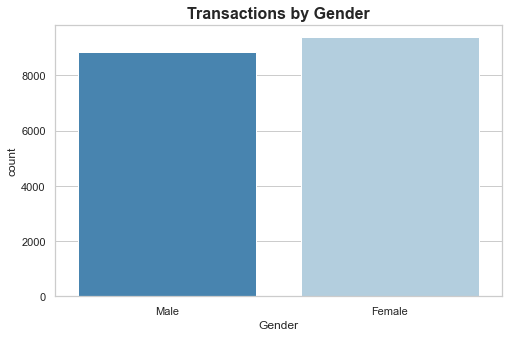

In [73]:
plt.figure(figsize=(8,5))
sns.countplot(x='gender', data=df, palette='Blues_r')
plt.xlabel('Gender')
plt.title('Transactions by Gender', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Total Bike Purchases vs Gender')

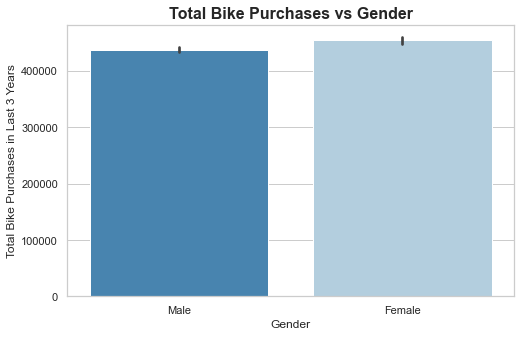

In [74]:
plt.figure(figsize=(8,5))
sns.barplot(x='gender', y='past_3_years_bike_related_purchases', data=df, palette='Blues_r', estimator=sum)
plt.xlabel('Gender')
plt.ylabel('Total Bike Purchases in Last 3 Years')
plt.title('Total Bike Purchases vs Gender', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Transactions by State')

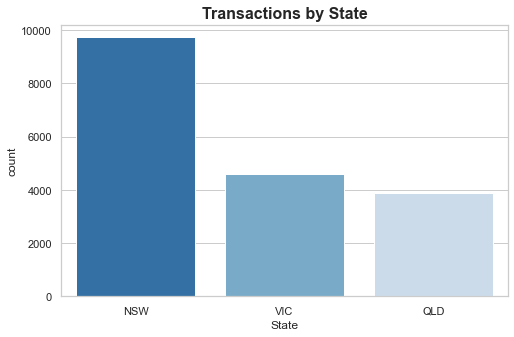

In [75]:
plt.figure(figsize=(8,5))
sns.countplot(x='state', data=df, order=['NSW', 'VIC', 'QLD'], palette='Blues_r')
plt.xlabel('State')
plt.title('Transactions by State', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Total Bike Purchases vs State')

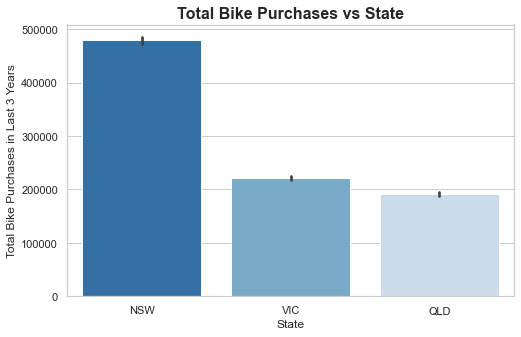

In [76]:
plt.figure(figsize=(8,5))
sns.barplot(x='state', y='past_3_years_bike_related_purchases',  order=['NSW', 'VIC', 'QLD'], data=df, 
            palette='Blues_r', estimator=sum)
plt.xlabel('State')
plt.ylabel('Total Bike Purchases in Last 3 Years')
plt.title('Total Bike Purchases vs State', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Transactions by Customers who owns car')

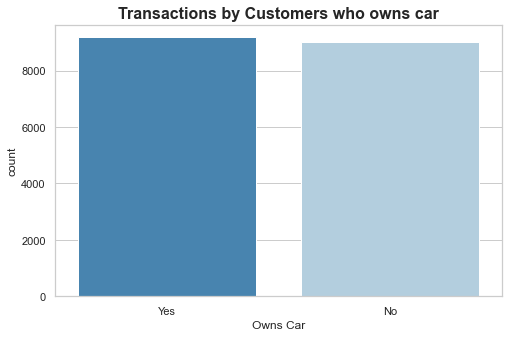

In [77]:
plt.figure(figsize=(8,5))
sns.countplot(x='owns_car', data=df, palette='Blues_r')
plt.xlabel('Owns Car')
plt.title('Transactions by Customers who owns car', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Total Bike Purchases vs Customers with car')

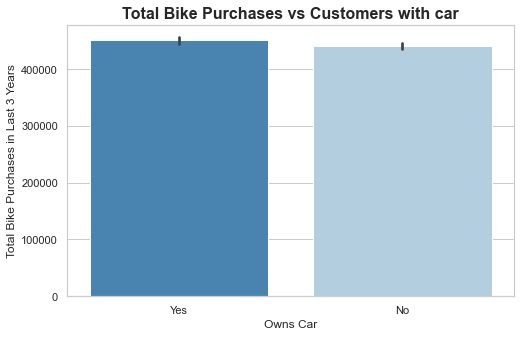

In [78]:
plt.figure(figsize=(8,5))
sns.barplot(x='owns_car', y='past_3_years_bike_related_purchases', data=df, palette='Blues_r', estimator=sum)
plt.xlabel('Owns Car')
plt.ylabel('Total Bike Purchases in Last 3 Years')
plt.title('Total Bike Purchases vs Customers with car', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Transactions by Wealth Segment')

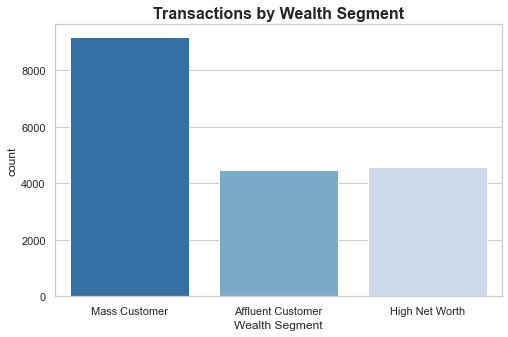

In [79]:
plt.figure(figsize=(8,5))
sns.countplot(x='wealth_segment', data=df, palette='Blues_r')
plt.xlabel('Wealth Segment')
plt.title('Transactions by Wealth Segment', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Total Bike Purchases vs Wealth Segment')

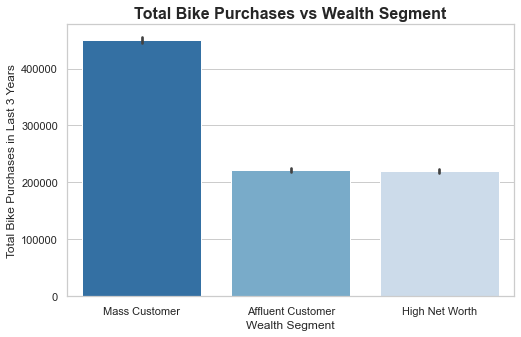

In [80]:
plt.figure(figsize=(8,5))
sns.barplot(x='wealth_segment', y='past_3_years_bike_related_purchases', data=df, palette='Blues_r', estimator=sum)
plt.xlabel('Wealth Segment')
plt.ylabel('Total Bike Purchases in Last 3 Years')
plt.title('Total Bike Purchases vs Wealth Segment', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Transactions by Age Group')

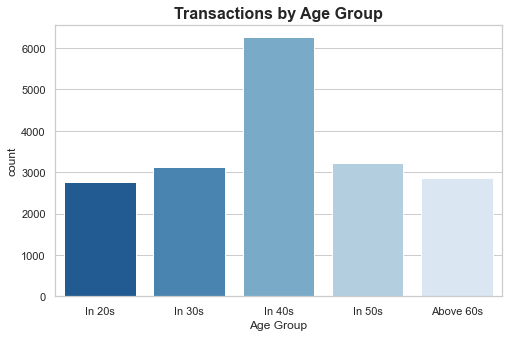

In [81]:
plt.figure(figsize=(8,5))
sns.countplot(x='age_group', data=df, order=['In 20s', 'In 30s', 'In 40s', 'In 50s', 'Above 60s'],
              palette='Blues_r')
plt.xlabel('Age Group')
plt.title('Transactions by Age Group', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Total Bike Purchases vs Age Group')

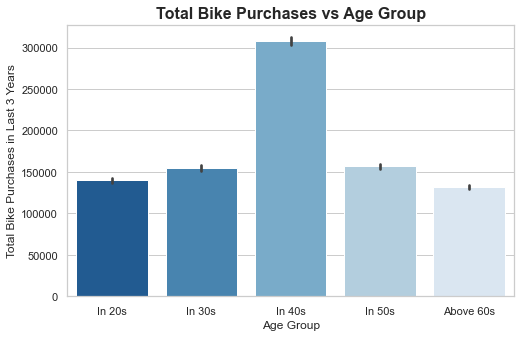

In [82]:
plt.figure(figsize=(8,5))
sns.barplot(x='age_group', y='past_3_years_bike_related_purchases', data=df, order=['In 20s', 'In 30s', 'In 40s', 'In 50s', 'Above 60s'],
            palette='Blues_r', estimator=sum)
plt.xlabel('Age Group')
plt.ylabel('Total Bike Purchases in Last 3 Years')
plt.title('Total Bike Purchases vs Age Group', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Total Transactions in 2017 by Property Valuation')

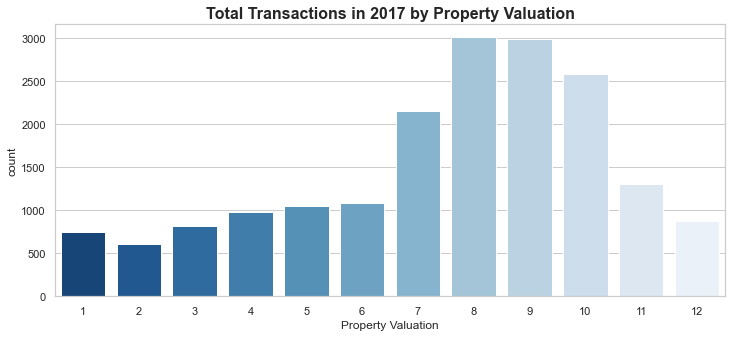

In [83]:
plt.figure(figsize=(12,5))
sns.countplot(x='property_valuation', data=df, palette='Blues_r')
plt.xlabel('Property Valuation')
plt.title('Total Transactions in 2017 by Property Valuation', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Total Bike Purchases vs Property Valuation')

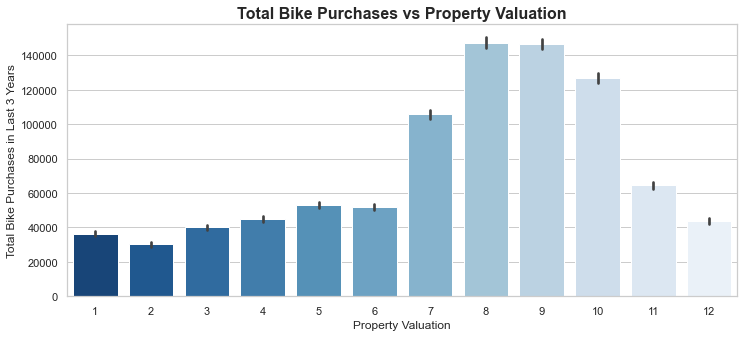

In [84]:
plt.figure(figsize=(12,5))
sns.barplot(x='property_valuation', y='past_3_years_bike_related_purchases', data=df, palette='Blues_r', estimator=sum)
plt.xlabel('Property Valuation')
plt.ylabel('Total Bike Purchases in Last 3 Years')
plt.title('Total Bike Purchases vs Property Valuation', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Total Transactions in 2017 by Tenure')

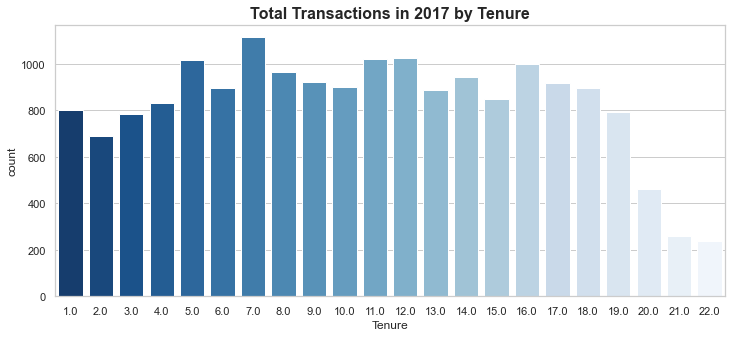

In [85]:
plt.figure(figsize=(12,5))
sns.countplot(x='tenure', data=df, palette='Blues_r')
plt.xlabel('Tenure')
plt.title('Total Transactions in 2017 by Tenure', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Total Bike Purchases vs Tenure')

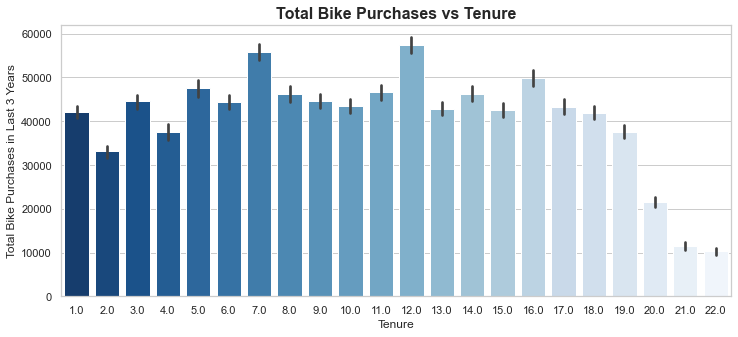

In [86]:
plt.figure(figsize=(12,5))
sns.barplot(x='tenure', y='past_3_years_bike_related_purchases', data=df, palette='Blues_r', estimator=sum)
plt.xlabel('Tenure')
plt.ylabel('Total Bike Purchases in Last 3 Years')
plt.title('Total Bike Purchases vs Tenure', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Total Transactions in 2017 by Job Industry')

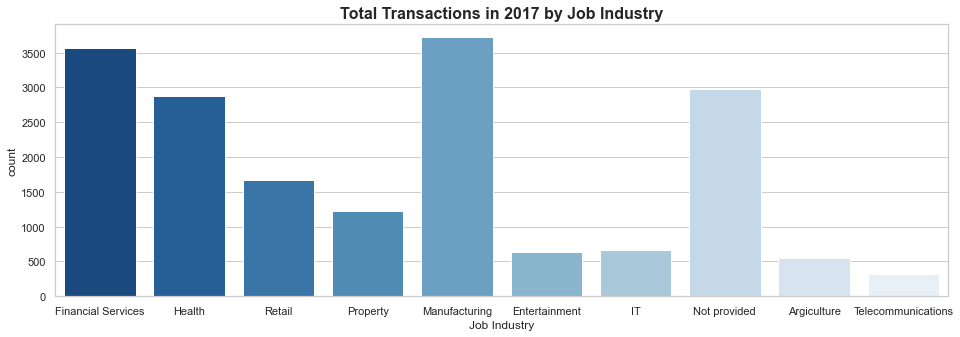

In [87]:
plt.figure(figsize=(16,5))
sns.countplot(x='job_industry_category', data=df, palette='Blues_r')
plt.xlabel('Job Industry')
plt.title('Total Transactions in 2017 by Job Industry', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Total Bike Purchases vs Job Industry')

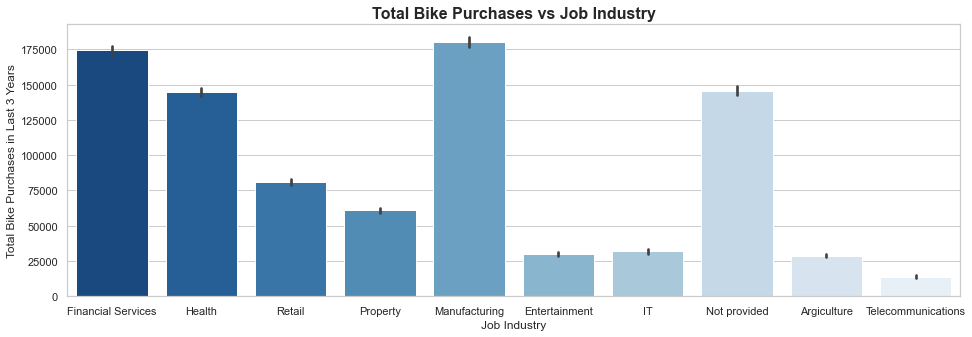

In [88]:
plt.figure(figsize=(16,5))
sns.barplot(x='job_industry_category', y='past_3_years_bike_related_purchases', data=df, palette='Blues_r', estimator=sum)
plt.xlabel('Job Industry')
plt.ylabel('Total Bike Purchases in Last 3 Years')
plt.title('Total Bike Purchases vs Job Industry', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Total Bike Purchases vs State by Customer with car')

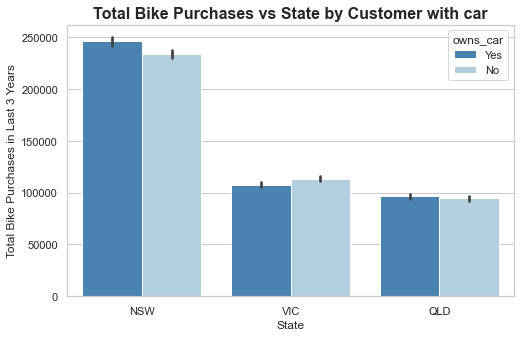

In [89]:
plt.figure(figsize=(8,5))
sns.barplot(x='state', y='past_3_years_bike_related_purchases', hue='owns_car', order=['NSW', 'VIC', 'QLD'],
            data=df, palette='Blues_r', estimator=sum)
plt.xlabel('State')
plt.ylabel('Total Bike Purchases in Last 3 Years')
plt.title('Total Bike Purchases vs State by Customer with car', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Total Transactions in 2017 vs State by Customer with car')

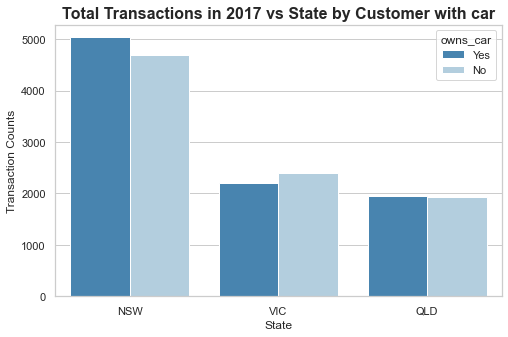

In [90]:
plt.figure(figsize=(8,5))
sns.countplot(x='state', order=['NSW', 'VIC', 'QLD'], hue='owns_car', data=df, palette='Blues_r')
plt.xlabel('State')
plt.ylabel('Transaction Counts')
plt.title('Total Transactions in 2017 vs State by Customer with car', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Total Bike Purchases vs State by Gender')

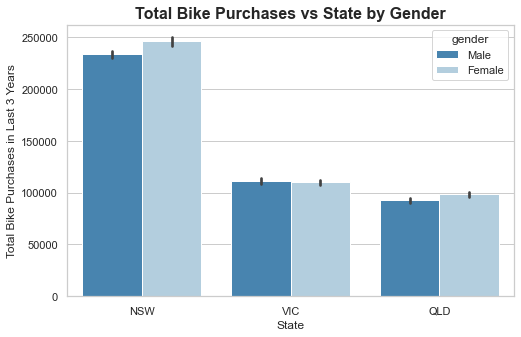

In [91]:
plt.figure(figsize=(8,5))
sns.barplot(x='state', y='past_3_years_bike_related_purchases', hue='gender', order=['NSW', 'VIC', 'QLD'],
            data=df, palette='Blues_r', estimator=sum)
plt.xlabel('State')
plt.ylabel('Total Bike Purchases in Last 3 Years')
plt.title('Total Bike Purchases vs State by Gender', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Total Transactions in 2017 vs State by Gender')

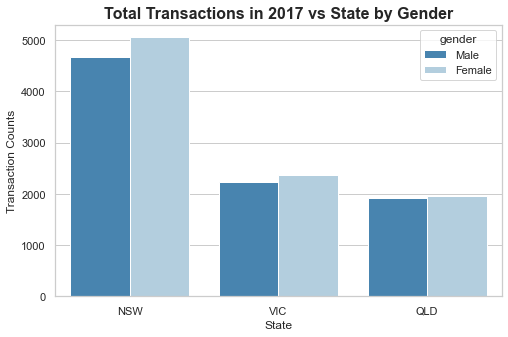

In [92]:
plt.figure(figsize=(8,5))
sns.countplot(x='state', order=['NSW', 'VIC', 'QLD'], hue='gender', data=df, palette='Blues_r')
plt.xlabel('State')
plt.ylabel('Transaction Counts')
plt.title('Total Transactions in 2017 vs State by Gender', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Total Bike Purchases vs State by Wealth Segment')

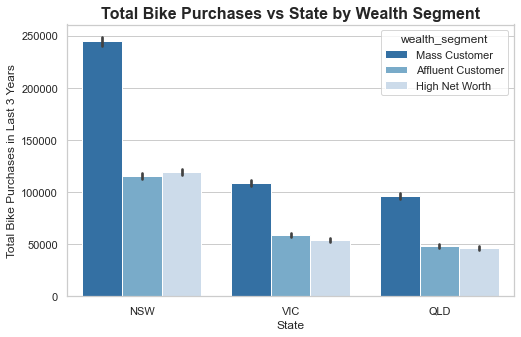

In [93]:
plt.figure(figsize=(8,5))
sns.barplot(x='state', y='past_3_years_bike_related_purchases', hue='wealth_segment', order=['NSW', 'VIC', 'QLD'],
            data=df, palette='Blues_r', estimator=sum)
plt.xlabel('State')
plt.ylabel('Total Bike Purchases in Last 3 Years')
plt.title('Total Bike Purchases vs State by Wealth Segment', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Total Transactions in 2017 vs State by Wealth Segment')

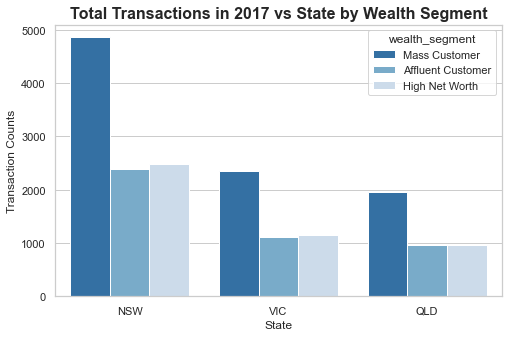

In [94]:
plt.figure(figsize=(8,5))
sns.countplot(x='state', order=['NSW', 'VIC', 'QLD'], hue='wealth_segment', data=df, palette='Blues_r')
plt.xlabel('State')
plt.ylabel('Transaction Counts')
plt.title('Total Transactions in 2017 vs State by Wealth Segment', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Total Bike Purchases vs Age Group by Gender')

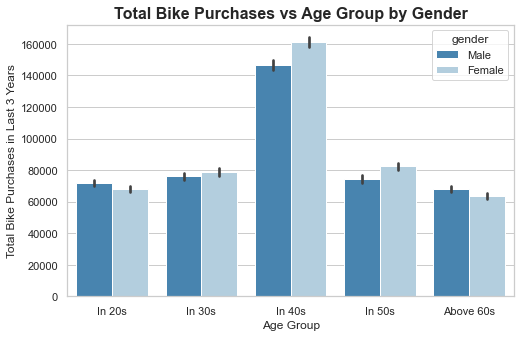

In [95]:
plt.figure(figsize=(8,5))
sns.barplot(x='age_group', y='past_3_years_bike_related_purchases', order=['In 20s', 'In 30s', 'In 40s', 'In 50s', 'Above 60s'],
            hue='gender', data=df, palette='Blues_r', estimator=sum)
plt.xlabel('Age Group')
plt.ylabel('Total Bike Purchases in Last 3 Years')
plt.title('Total Bike Purchases vs Age Group by Gender', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Total Transactions in 2017 vs Age Group by Gender')

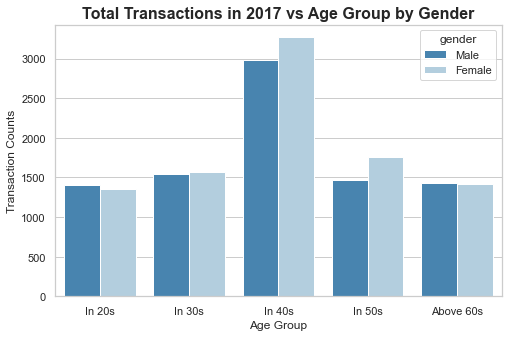

In [96]:
plt.figure(figsize=(8,5))
sns.countplot(x='age_group', order=['In 20s', 'In 30s', 'In 40s', 'In 50s', 'Above 60s'], hue='gender', data=df, palette='Blues_r')
plt.xlabel('Age Group')
plt.ylabel('Transaction Counts')
plt.title('Total Transactions in 2017 vs Age Group by Gender', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Total Bike Purchases vs Age Group by Wealth Segment')

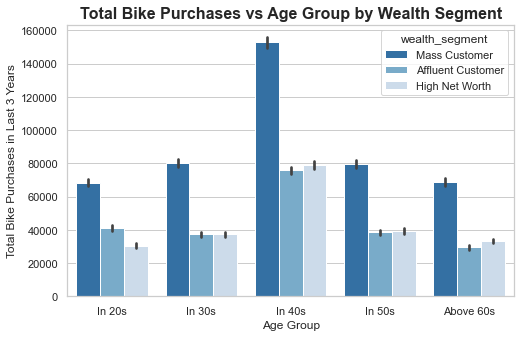

In [97]:
plt.figure(figsize=(8,5))
sns.barplot(x='age_group', y='past_3_years_bike_related_purchases', order=['In 20s', 'In 30s', 'In 40s', 'In 50s', 'Above 60s'],
            hue='wealth_segment', data=df, palette='Blues_r', estimator=sum)
plt.xlabel('Age Group')
plt.ylabel('Total Bike Purchases in Last 3 Years')
plt.title('Total Bike Purchases vs Age Group by Wealth Segment', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Total Transactions in 2017 vs Age Group by Wealth Segment')

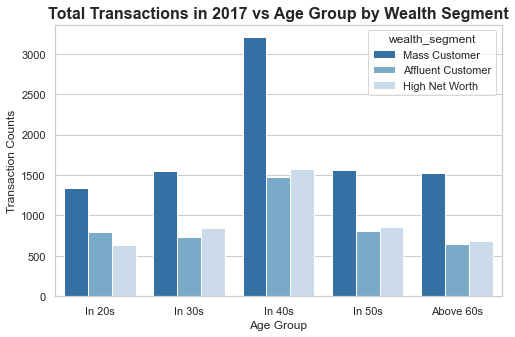

In [98]:
plt.figure(figsize=(8,5))
sns.countplot(x='age_group', order=['In 20s', 'In 30s', 'In 40s', 'In 50s', 'Above 60s'],
            hue='wealth_segment', data=df, palette='Blues_r')
plt.xlabel('Age Group')
plt.ylabel('Transaction Counts')
plt.title('Total Transactions in 2017 vs Age Group by Wealth Segment', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Total Bike Purchases vs Age Group by Customer with Car')

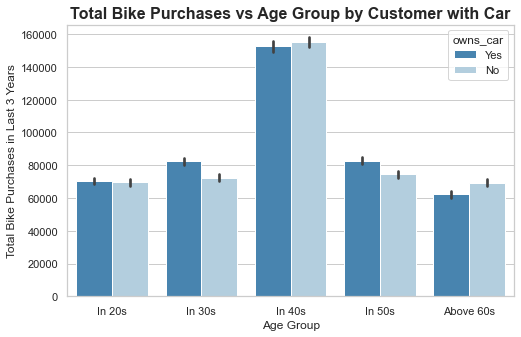

In [99]:
plt.figure(figsize=(8,5))
sns.barplot(x='age_group', y='past_3_years_bike_related_purchases', order=['In 20s', 'In 30s', 'In 40s', 'In 50s', 'Above 60s'],
            hue='owns_car', data=df, palette='Blues_r', estimator=sum)
plt.xlabel('Age Group')
plt.ylabel('Total Bike Purchases in Last 3 Years')
plt.title('Total Bike Purchases vs Age Group by Customer with Car', fontsize=16, fontweight='bold')

Text(0.5, 1.0, 'Total Transactions in 2017 vs Age Group by Customer with Car')

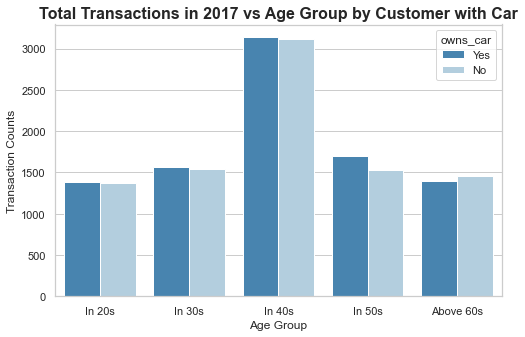

In [100]:
plt.figure(figsize=(8,5))
sns.countplot(x='age_group', order=['In 20s', 'In 30s', 'In 40s', 'In 50s', 'Above 60s'],
            hue='owns_car', data=df, palette='Blues_r')
plt.xlabel('Age Group')
plt.ylabel('Transaction Counts')
plt.title('Total Transactions in 2017 vs Age Group by Customer with Car', fontsize=16, fontweight='bold')

### RFM Analysis

RFM stands for recency, frequency, and monetary value which are important indicators as frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement. 

- Recency: the freshness of the customer's activity (purchase or visit)
- Frequency: the frequency of the customer's transactions or visits
- Monetary value: the intention of the customer to spend or the purchasing power of customer

[Source](https://clevertap.com/blog/rfm-analysis/)

In [101]:
# Create profits column (Monentary value)
df['profit'] = df['list_price'] - df['standard_cost']
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,...,tenure,address,postcode,state,country,property_valuation,year,age,age_group,profit
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,...,10.0,984 Hoepker Court,3064,VIC,Australia,6,1955,67,Above 60s,17.87
1,11065,1,2950,2017-10-16,0.0,Approved,Giant Bicycles,Standard,medium,medium,...,10.0,984 Hoepker Court,3064,VIC,Australia,6,1955,67,Above 60s,448.68
2,18923,62,2950,2017-04-26,0.0,Approved,Solex,Standard,medium,medium,...,10.0,984 Hoepker Court,3064,VIC,Australia,6,1955,67,Above 60s,179.44
3,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,...,10.0,4 Shopko Circle,2196,NSW,Australia,5,1979,43,In 40s,1702.55
4,6862,4,3120,2017-10-05,0.0,Approved,Giant Bicycles,Standard,high,medium,...,10.0,4 Shopko Circle,2196,NSW,Australia,5,1979,43,In 40s,451.65


In [102]:
# The max transaction date in the dataset is 2017-12-30 which will be used to compare and calculate the recency for each transaction.
print('Latest transaction date:', max(df['transaction_date']))

Latest transaction date: 2017-12-30 00:00:00


In [103]:
# Create a function to calculate the recency
def cal_recency(date):
    comparison_date = pd.to_datetime('2017-12-30').normalize()
    result = comparison_date - date
    return result.days

In [104]:
# Create recency column and apply the cal_recency function
df['recency'] = df['transaction_date'].apply(cal_recency)
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,...,address,postcode,state,country,property_valuation,year,age,age_group,profit,recency
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,...,984 Hoepker Court,3064,VIC,Australia,6,1955,67,Above 60s,17.87,308
1,11065,1,2950,2017-10-16,0.0,Approved,Giant Bicycles,Standard,medium,medium,...,984 Hoepker Court,3064,VIC,Australia,6,1955,67,Above 60s,448.68,75
2,18923,62,2950,2017-04-26,0.0,Approved,Solex,Standard,medium,medium,...,984 Hoepker Court,3064,VIC,Australia,6,1955,67,Above 60s,179.44,248
3,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,...,4 Shopko Circle,2196,NSW,Australia,5,1979,43,In 40s,1702.55,223
4,6862,4,3120,2017-10-05,0.0,Approved,Giant Bicycles,Standard,high,medium,...,4 Shopko Circle,2196,NSW,Australia,5,1979,43,In 40s,451.65,86


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18206 entries, 0 to 18367
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   transaction_id                       18206 non-null  int64         
 1   product_id                           18206 non-null  int64         
 2   customer_id                          18206 non-null  int64         
 3   transaction_date                     18206 non-null  datetime64[ns]
 4   online_order                         18206 non-null  float64       
 5   order_status                         18206 non-null  object        
 6   brand                                18206 non-null  object        
 7   product_line                         18206 non-null  object        
 8   product_class                        18206 non-null  object        
 9   product_size                         18206 non-null  object        
 10  list_price

In [106]:
# Create the RFM table using groupby function
rfm_table = df.groupby('customer_id').agg({'recency': lambda x:x.min(),
                                            'product_id': lambda x: len(x),
                                            'profit': lambda x: x.sum()})

rfm_table.rename(columns={'recency': 'recency', 
                         'product_id': 'frequency', 
                         'profit': 'monetary_value'}, inplace=True)

rfm_table.head()

,recency,frequency,monetary_value
customer_id,,,
1,7,11,3018.09
2,128,3,2226.26
5,16,6,2394.94
6,64,5,3946.55
7,253,3,220.11


In [107]:
# Check the quartiles of rfm table to define the score
quartiles = rfm_table.quantile(q=[0.25,0.50,0.75])
print(quartiles)

      recency  frequency  monetary_value
0.25     18.0        4.0        1777.320
0.50     45.0        5.0        2770.160
0.75     88.0        7.0        4077.225


In [108]:
# Create columns for r_score, f_score and m_score
rfm_table['r_score'] = 0
rfm_table['f_score'] = 0
rfm_table['m_score'] = 0

In [109]:
# Calculate the r_score
for i in rfm_table.index:
    if (int(rfm_table['recency'][i])) > 88:
        rfm_table['r_score'][i] = 1
    elif ((int(rfm_table['recency'][i])) <= 88) & ((int(rfm_table['recency'][i])) > 45):
        rfm_table['r_score'][i] = 2
    elif ((int(rfm_table['recency'][i])) <= 45) & ((int(rfm_table['recency'][i])) > 18):
        rfm_table['r_score'][i] = 3
    else:
        rfm_table['r_score'][i] = 4

In [110]:
# Calculate the f_score
for i in rfm_table.index:
    if (int(rfm_table['frequency'][i])) > 7:
        rfm_table['f_score'][i] = 1
    elif ((int(rfm_table['frequency'][i])) <= 7) & ((int(rfm_table['frequency'][i])) > 5):
        rfm_table['f_score'][i] = 2
    elif ((int(rfm_table['frequency'][i])) <= 5) & ((int(rfm_table['frequency'][i])) > 4):
        rfm_table['f_score'][i] = 3
    else:
        rfm_table['f_score'][i] = 4

In [111]:
# Calculate the m_score
for i in rfm_table.index:
    if (int(rfm_table['monetary_value'][i])) > 4077:
        rfm_table['m_score'][i] = 1
    elif ((int(rfm_table['monetary_value'][i])) <= 4077) & ((int(rfm_table['monetary_value'][i])) > 2770):
        rfm_table['m_score'][i] = 2
    elif ((int(rfm_table['monetary_value'][i])) <= 2770) & ((int(rfm_table['monetary_value'][i])) > 1777):
        rfm_table['m_score'][i] = 3
    else:
        rfm_table['m_score'][i] = 4

In [112]:
# Calculate the total rfm score
rfm_table['rfm_score'] = rfm_table['r_score'].astype(str) + rfm_table['f_score'].astype(str) + rfm_table['m_score'].astype(str)

In [113]:
rfm_table

,recency,frequency,monetary_value,r_score,f_score,m_score,rfm_score
customer_id,,,,,,,
1,7,11,3018.09,4,1,2,412
2,128,3,2226.26,1,4,3,143
5,16,6,2394.94,4,2,3,423
6,64,5,3946.55,2,3,2,232
7,253,3,220.11,1,4,4,144
...,...,...,...,...,...,...,...
3496,256,4,2045.84,1,4,3,143
3497,52,3,1648.32,2,4,4,244
3498,127,6,3147.33,1,2,2,122


In [114]:
# Create a function to define the best customer (return as 1).
# This will be used as the target for the modelling.
def rfm_label(rfm_score):
    if rfm_score in ['444','443','434','433','344','343','334','333','244','243','234','233']: 
        return 1
    else: 
        return 0

In [115]:
# Create target column and apply the rfm_label function
rfm_table['target'] = rfm_table['rfm_score'].apply(rfm_label)
rfm_table

,recency,frequency,monetary_value,r_score,f_score,m_score,rfm_score,target
customer_id,,,,,,,,
1,7,11,3018.09,4,1,2,412,0
2,128,3,2226.26,1,4,3,143,0
5,16,6,2394.94,4,2,3,423,0
6,64,5,3946.55,2,3,2,232,0
7,253,3,220.11,1,4,4,144,0
...,...,...,...,...,...,...,...,...
3496,256,4,2045.84,1,4,3,143,0
3497,52,3,1648.32,2,4,4,244,1
3498,127,6,3147.33,1,2,2,122,0


In [116]:
# Count the number of targets
rfm_table.groupby('target')['target'].count()

target
0    2495
1     804
Name: target, dtype: int64

In [117]:
# Extract the target values out to merge the info with the customer_df for train dataset
target_value = rfm_table[['target']]
target_value.head()

,target
customer_id,
1,0
2,0
5,0
6,0
7,0


In [118]:
# Merge rfm table with customer_df for dashboard visualization
customers = customer_df.merge(rfm_table, on='customer_id')
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3299 entries, 0 to 3298
Data columns (total 28 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          3299 non-null   int64         
 1   first_name                           3299 non-null   object        
 2   last_name                            3299 non-null   object        
 3   gender                               3299 non-null   object        
 4   past_3_years_bike_related_purchases  3299 non-null   int64         
 5   DOB                                  3299 non-null   datetime64[ns]
 6   job_title                            3299 non-null   object        
 7   job_industry_category                3299 non-null   object        
 8   wealth_segment                       3299 non-null   object        
 9   deceased_indicator                   3299 non-null   object        
 10  owns_car    

In [180]:
# Export data set to csv file
customers.to_excel('../customers.xlsx', index=False)

## Train and Test Datasets Preparation

### Train dataset

In [121]:
train_df = customer_df
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3787 entries, 0 to 3786
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          3787 non-null   int64         
 1   first_name                           3787 non-null   object        
 2   last_name                            3787 non-null   object        
 3   gender                               3787 non-null   object        
 4   past_3_years_bike_related_purchases  3787 non-null   int64         
 5   DOB                                  3787 non-null   datetime64[ns]
 6   job_title                            3787 non-null   object        
 7   job_industry_category                3787 non-null   object        
 8   wealth_segment                       3787 non-null   object        
 9   deceased_indicator                   3787 non-null   object        
 10  owns_car    

In [122]:
# Merge rfm_table with train_df
train_df = train_df.merge(target_value, on='customer_id')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3299 entries, 0 to 3298
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          3299 non-null   int64         
 1   first_name                           3299 non-null   object        
 2   last_name                            3299 non-null   object        
 3   gender                               3299 non-null   object        
 4   past_3_years_bike_related_purchases  3299 non-null   int64         
 5   DOB                                  3299 non-null   datetime64[ns]
 6   job_title                            3299 non-null   object        
 7   job_industry_category                3299 non-null   object        
 8   wealth_segment                       3299 non-null   object        
 9   deceased_indicator                   3299 non-null   object        
 10  owns_car    

In [123]:
train_df = train_df.set_index('customer_id')
train_df.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation,year,age,age_group,target
customer_id,,,,,,,,,,,,,,,,,,,,
1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,060 Morning Avenue,2016,NSW,Australia,10,1953,69,Above 60s,0
2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0,6 Meadow Vale Court,2153,NSW,Australia,10,1980,42,In 40s,0
5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,Not provided,Affluent Customer,N,Yes,8.0,17979 Del Mar Point,2448,NSW,Australia,4,1977,45,In 40s,0
6,Curr,Duckhouse,Male,35,1966-09-16,Not provided,Retail,High Net Worth,N,Yes,13.0,9 Oakridge Court,3216,VIC,Australia,9,1966,56,In 50s,0
7,Fina,Merali,Female,6,1976-02-23,Not provided,Financial Services,Affluent Customer,N,Yes,11.0,4 Delaware Trail,2210,NSW,Australia,9,1976,46,In 40s,0


In [124]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3299 entries, 1 to 3500
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   first_name                           3299 non-null   object        
 1   last_name                            3299 non-null   object        
 2   gender                               3299 non-null   object        
 3   past_3_years_bike_related_purchases  3299 non-null   int64         
 4   DOB                                  3299 non-null   datetime64[ns]
 5   job_title                            3299 non-null   object        
 6   job_industry_category                3299 non-null   object        
 7   wealth_segment                       3299 non-null   object        
 8   deceased_indicator                   3299 non-null   object        
 9   owns_car                             3299 non-null   object        
 10  tenure      

In [125]:
train_df.columns

Index(['first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'address', 'postcode', 'state', 'country',
       'property_valuation', 'year', 'age', 'age_group', 'target'],
      dtype='object')

In [126]:
# Drop columns that are not used for modelling
train_df.drop(['first_name', 'last_name', 'DOB', 'job_title', 'deceased_indicator', 'address', 'postcode', 'country', 
               'year', 'age'], axis=1, inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3299 entries, 1 to 3500
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   gender                               3299 non-null   object 
 1   past_3_years_bike_related_purchases  3299 non-null   int64  
 2   job_industry_category                3299 non-null   object 
 3   wealth_segment                       3299 non-null   object 
 4   owns_car                             3299 non-null   object 
 5   tenure                               3299 non-null   float64
 6   state                                3299 non-null   object 
 7   property_valuation                   3299 non-null   int64  
 8   age_group                            3299 non-null   object 
 9   target                               3299 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 283.5+ KB


In [127]:
# Dummify the categorical features
train_df = pd.get_dummies(train_df, columns=['gender', 'job_industry_category', 'wealth_segment', 'owns_car', 'state', 
                                             'age_group'])
train_df.shape

(3299, 29)

In [128]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3299 entries, 1 to 3500
Data columns (total 29 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   past_3_years_bike_related_purchases       3299 non-null   int64  
 1   tenure                                    3299 non-null   float64
 2   property_valuation                        3299 non-null   int64  
 3   target                                    3299 non-null   int64  
 4   gender_Female                             3299 non-null   uint8  
 5   gender_Male                               3299 non-null   uint8  
 6   job_industry_category_Argiculture         3299 non-null   uint8  
 7   job_industry_category_Entertainment       3299 non-null   uint8  
 8   job_industry_category_Financial Services  3299 non-null   uint8  
 9   job_industry_category_Health              3299 non-null   uint8  
 10  job_industry_category_IT            

In [129]:
# Generate correlation matrix
df_corr = train_df.corr()
df_corr

,past_3_years_bike_related_purchases,tenure,property_valuation,target,gender_Female,gender_Male,job_industry_category_Argiculture,job_industry_category_Entertainment,job_industry_category_Financial Services,job_industry_category_Health,...,owns_car_No,owns_car_Yes,state_NSW,state_QLD,state_VIC,age_group_Above 60s,age_group_In 20s,age_group_In 30s,age_group_In 40s,age_group_In 50s
past_3_years_bike_related_purchases,1.000000,-0.019636,0.007285,0.032623,-0.022408,0.022408,0.019652,-0.015645,-0.004701,0.020419,...,0.000298,-0.000298,-0.002216,0.002508,0.000182,-0.029417,0.015046,0.011765,0.012654,-0.013639
tenure,-0.019636,1.000000,-0.016183,-0.001316,0.000788,-0.000788,-0.003449,0.015677,-0.017710,0.001759,...,0.010091,-0.010091,-0.007643,0.010648,-0.001254,0.136385,-0.535702,-0.023728,0.239669,0.097274
property_valuation,0.007285,-0.016183,1.000000,0.002133,0.009081,-0.009081,0.001634,0.012343,-0.005685,0.032089,...,-0.048958,0.048958,0.343434,-0.369484,-0.046213,0.011541,-0.007530,-0.014897,0.001514,0.009000
target,0.032623,-0.001316,0.002133,1.000000,0.011592,-0.011592,0.003611,-0.005780,-0.004655,0.006279,...,0.000683,-0.000683,0.006831,-0.003596,-0.004451,-0.005014,-0.007190,0.023024,-0.001671,-0.009266
gender_Female,-0.022408,0.000788,0.009081,0.011592,1.000000,-1.000000,-0.003823,-0.001187,-0.009007,-0.006948,...,-0.008968,0.008968,0.004226,-0.010628,0.005154,-0.007683,-0.014229,-0.015400,0.006986,0.027039
gender_Male,0.022408,-0.000788,-0.009081,-0.011592,-1.000000,1.000000,0.003823,0.001187,0.009007,0.006948,...,0.008968,-0.008968,-0.004226,0.010628,-0.005154,0.007683,0.014229,0.015400,-0.006986,-0.027039
job_industry_category_Argiculture,0.019652,-0.003449,0.001634,0.003611,-0.003823,0.003823,1.000000,-0.033728,-0.087545,-0.075389,...,-0.024253,0.024253,0.004110,0.043121,-0.045289,-0.005984,0.000724,-0.000915,0.014965,-0.012673
job_industry_category_Entertainment,-0.015645,0.015677,0.012343,-0.005780,-0.001187,0.001187,-0.033728,1.000000,-0.095441,-0.082188,...,0.027202,-0.027202,-0.017920,0.004418,0.016394,-0.009002,-0.002549,0.002935,-0.004080,0.012993
job_industry_category_Financial Services,-0.004701,-0.017710,-0.005685,-0.004655,-0.009007,0.009007,-0.087545,-0.095441,1.000000,-0.213332,...,-0.024368,0.024368,-0.000971,0.025290,-0.022683,-0.026680,0.044089,0.016515,-0.014325,-0.014545
job_industry_category_Health,0.020419,0.001759,0.032089,0.006279,-0.006948,0.006948,-0.075389,-0.082188,-0.213332,1.000000,...,0.010870,-0.010870,0.016270,-0.042849,0.021660,-0.013198,-0.001930,-0.030779,0.009097,0.033352


Text(0.5, 1.0, 'Correlation Matrix')

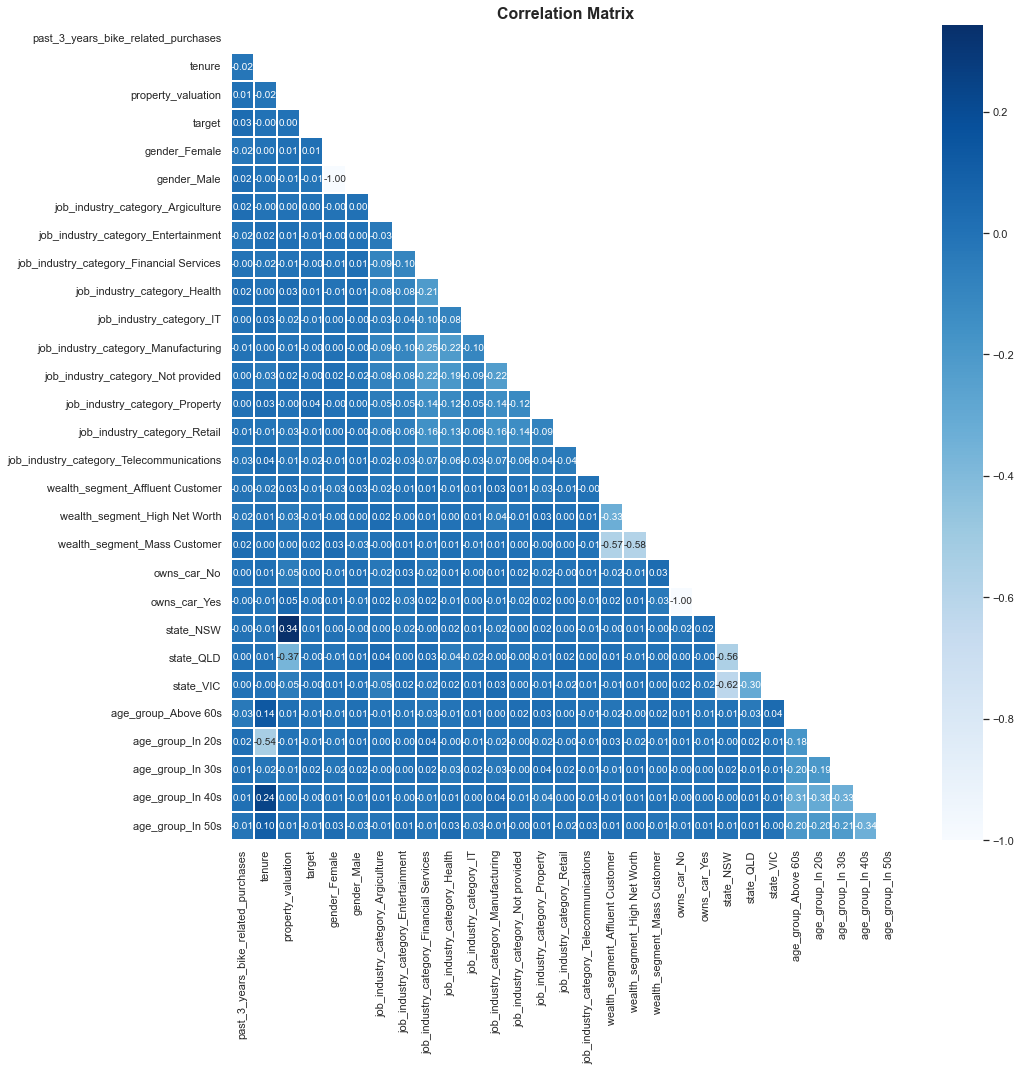

In [130]:
# Plot heatmap
plt.figure(figsize=(15,15))

# Create the matrix to mask the correlation matrix
matrix = np.triu(df_corr)
sns.heatmap(df_corr, annot=True, cmap='Blues', fmt='.2f', linewidths=2, mask=matrix, annot_kws={'fontsize':10})

# Set title for the plot
plt.title('Correlation Matrix', loc='center', fontsize=16, fontweight='bold')

Slight correlation observed for state, age group and wealth segment. As the dataset is imbalance, the correlation is not very obvious. 

### Test dataset

- There are 1,000 new customer records.
- Missing data is observed for last_name, DOB, job_title and job_industry_category.
- No duplicate data recorded.
- There are 5 unnamed columns observed that contains float datatype.
- Columns in the test dataset will be handled to be the same as the train dataset.

In [131]:
# Read the NewCustomerList worksheet
test_df = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', sheet_name='NewCustomerList', skiprows=[0], parse_dates=True)

In [132]:
test_df.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,state,country,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,...,QLD,Australia,6,0.56,0.7000,0.8750,0.743750,1,1,1.718750
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,...,NSW,Australia,11,0.89,0.8900,1.1125,0.945625,1,1,1.718750
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,...,VIC,Australia,5,1.01,1.0100,1.0100,1.010000,1,1,1.718750
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,...,QLD,Australia,1,0.87,1.0875,1.0875,1.087500,4,4,1.703125
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,...,NSW,Australia,9,0.52,0.5200,0.6500,0.650000,4,4,1.703125


In [133]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   first_name                           1000 non-null   object        
 1   last_name                            971 non-null    object        
 2   gender                               1000 non-null   object        
 3   past_3_years_bike_related_purchases  1000 non-null   int64         
 4   DOB                                  983 non-null    datetime64[ns]
 5   job_title                            894 non-null    object        
 6   job_industry_category                835 non-null    object        
 7   wealth_segment                       1000 non-null   object        
 8   deceased_indicator                   1000 non-null   object        
 9   owns_car                             1000 non-null   object        
 10  tenure       

In [134]:
# Check missing values
test_df.isnull().sum()

first_name                               0
last_name                               29
gender                                   0
past_3_years_bike_related_purchases      0
DOB                                     17
job_title                              106
job_industry_category                  165
wealth_segment                           0
deceased_indicator                       0
owns_car                                 0
tenure                                   0
address                                  0
postcode                                 0
state                                    0
country                                  0
property_valuation                       0
Unnamed: 16                              0
Unnamed: 17                              0
Unnamed: 18                              0
Unnamed: 19                              0
Unnamed: 20                              0
Rank                                     0
Value                                    0
dtype: int6

In [135]:
# Create age column
test_df['year'] = pd.DatetimeIndex(test_df['DOB']).year
test_df['age'] = 2022 - test_df['year']
test_df.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value,year,age
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,...,6,0.56,0.7000,0.8750,0.743750,1,1,1.718750,1957.0,65.0
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,...,11,0.89,0.8900,1.1125,0.945625,1,1,1.718750,1970.0,52.0
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,...,5,1.01,1.0100,1.0100,1.010000,1,1,1.718750,1974.0,48.0
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,...,1,0.87,1.0875,1.0875,1.087500,4,4,1.703125,1979.0,43.0
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,...,9,0.52,0.5200,0.6500,0.650000,4,4,1.703125,1965.0,57.0


In [136]:
# Create a column for age group and apply age_category function
test_df['age_group'] = test_df['age'].apply(age_category)
test_df.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value,year,age,age_group
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,...,0.56,0.7000,0.8750,0.743750,1,1,1.718750,1957.0,65.0,Above 60s
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,...,0.89,0.8900,1.1125,0.945625,1,1,1.718750,1970.0,52.0,In 50s
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,...,1.01,1.0100,1.0100,1.010000,1,1,1.718750,1974.0,48.0,In 40s
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,...,0.87,1.0875,1.0875,1.087500,4,4,1.703125,1979.0,43.0,In 40s
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,...,0.52,0.5200,0.6500,0.650000,4,4,1.703125,1965.0,57.0,In 50s


In [137]:
# Delete unnamed, rank and value columns as these data are not in the train dataset
test_df.drop(['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Rank', 'Value', 'first_name', 
              'last_name', 'DOB', 'job_title', 'deceased_indicator', 'address', 'postcode', 'country', 'year', 
              'age'], axis=1, inplace=True)

In [138]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   gender                               1000 non-null   object
 1   past_3_years_bike_related_purchases  1000 non-null   int64 
 2   job_industry_category                835 non-null    object
 3   wealth_segment                       1000 non-null   object
 4   owns_car                             1000 non-null   object
 5   tenure                               1000 non-null   int64 
 6   state                                1000 non-null   object
 7   property_valuation                   1000 non-null   int64 
 8   age_group                            1000 non-null   object
dtypes: int64(3), object(6)
memory usage: 70.4+ KB


In [139]:
# Replace the null values for job_industry_category with 'Not provided'
test_df['job_industry_category'] = test_df['job_industry_category'].replace([np.nan], 'Not provided')
test_df['job_industry_category'].value_counts()

Financial Services    203
Manufacturing         199
Not provided          165
Health                152
Retail                 78
Property               64
IT                     51
Entertainment          37
Argiculture            26
Telecommunications     25
Name: job_industry_category, dtype: int64

In [140]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   gender                               1000 non-null   object
 1   past_3_years_bike_related_purchases  1000 non-null   int64 
 2   job_industry_category                1000 non-null   object
 3   wealth_segment                       1000 non-null   object
 4   owns_car                             1000 non-null   object
 5   tenure                               1000 non-null   int64 
 6   state                                1000 non-null   object
 7   property_valuation                   1000 non-null   int64 
 8   age_group                            1000 non-null   object
dtypes: int64(3), object(6)
memory usage: 70.4+ KB


In [141]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   gender                               1000 non-null   object
 1   past_3_years_bike_related_purchases  1000 non-null   int64 
 2   job_industry_category                1000 non-null   object
 3   wealth_segment                       1000 non-null   object
 4   owns_car                             1000 non-null   object
 5   tenure                               1000 non-null   int64 
 6   state                                1000 non-null   object
 7   property_valuation                   1000 non-null   int64 
 8   age_group                            1000 non-null   object
dtypes: int64(3), object(6)
memory usage: 70.4+ KB


In [142]:
test_df.describe()

,past_3_years_bike_related_purchases,tenure,property_valuation
count,1000.000000,1000.000000,1000.000000
mean,49.836000,11.388000,7.397000
std,27.796686,5.037145,2.758804
min,0.000000,0.000000,1.000000
25%,26.750000,7.000000,6.000000
50%,51.000000,11.000000,8.000000
75%,72.000000,15.000000,9.000000
max,99.000000,22.000000,12.000000


In [143]:
test_df['gender'].value_counts()

Female    513
Male      470
U          17
Name: gender, dtype: int64

In [144]:
# Rename the gender 'U' to 'Undefined'
test_df['gender'] = test_df['gender'].replace(['U'], 'Undefined')
test_df['gender'].value_counts()

Female       513
Male         470
Undefined     17
Name: gender, dtype: int64

In [145]:
test_df['job_industry_category'].value_counts()

Financial Services    203
Manufacturing         199
Not provided          165
Health                152
Retail                 78
Property               64
IT                     51
Entertainment          37
Argiculture            26
Telecommunications     25
Name: job_industry_category, dtype: int64

In [146]:
test_df['wealth_segment'].value_counts()

Mass Customer        508
High Net Worth       251
Affluent Customer    241
Name: wealth_segment, dtype: int64

In [147]:
test_df['owns_car'].value_counts()

No     507
Yes    493
Name: owns_car, dtype: int64

In [148]:
test_df['tenure'].value_counts()

9     79
13    74
11    68
10    63
12    61
5     60
7     60
17    59
15    58
8     55
14    54
16    49
6     45
4     36
18    36
19    34
3     26
21    24
20    22
2     15
22    12
1      8
0      2
Name: tenure, dtype: int64

In [149]:
test_df['state'].value_counts()

NSW    506
VIC    266
QLD    228
Name: state, dtype: int64

In [150]:
# Dummify the categorical feature
test_df = pd.get_dummies(test_df, columns=['gender', 'job_industry_category', 'wealth_segment', 'owns_car', 'state', 
                                             'age_group'])
test_df.shape

(1000, 29)

In [151]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   past_3_years_bike_related_purchases       1000 non-null   int64
 1   tenure                                    1000 non-null   int64
 2   property_valuation                        1000 non-null   int64
 3   gender_Female                             1000 non-null   uint8
 4   gender_Male                               1000 non-null   uint8
 5   gender_Undefined                          1000 non-null   uint8
 6   job_industry_category_Argiculture         1000 non-null   uint8
 7   job_industry_category_Entertainment       1000 non-null   uint8
 8   job_industry_category_Financial Services  1000 non-null   uint8
 9   job_industry_category_Health              1000 non-null   uint8
 10  job_industry_category_IT                  1000 non-null   uin

In [152]:
# Drop the column gender_Undefined as this feature is not available in train_df
test_df.drop(['gender_Undefined'], axis=1, inplace=True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   past_3_years_bike_related_purchases       1000 non-null   int64
 1   tenure                                    1000 non-null   int64
 2   property_valuation                        1000 non-null   int64
 3   gender_Female                             1000 non-null   uint8
 4   gender_Male                               1000 non-null   uint8
 5   job_industry_category_Argiculture         1000 non-null   uint8
 6   job_industry_category_Entertainment       1000 non-null   uint8
 7   job_industry_category_Financial Services  1000 non-null   uint8
 8   job_industry_category_Health              1000 non-null   uint8
 9   job_industry_category_IT                  1000 non-null   uint8
 10  job_industry_category_Manufacturing       1000 non-null   uin

### Train/Test Split

In [153]:
# Create X and y variables
X = train_df.drop(columns = ['target'])
y = train_df['target']

In [154]:
# Split the dataset by 0.75 and 0.25
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify = y, random_state = 123)

# Check the shape of both train and val datasets
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(2474, 28) (825, 28) (2474,) (825,)


### Standard Scaling

In [155]:
# Scale the data
ss = StandardScaler()

# Fit and transform the data
Xs_train = ss.fit_transform(X_train)
Xs_val = ss.transform(X_val)

In [156]:
Xs_val

array([[-0.65352022, -1.70387431, -1.24616003, ..., -0.45737147,
        -0.72540911, -0.4631751 ],
       [-0.86318682, -0.29763269, -1.95310795, ..., -0.45737147,
        -0.72540911,  2.15901071],
       [ 0.04536844,  1.46016934, -0.89268606, ..., -0.45737147,
        -0.72540911, -0.4631751 ],
       ...,
       [-0.68846466,  0.05392772, -1.24616003, ..., -0.45737147,
        -0.72540911, -0.4631751 ],
       [ 0.88403483, -1.52809411,  0.52120979, ..., -0.45737147,
        -0.72540911, -0.4631751 ],
       [ 1.44314576, -0.8249733 , -1.24616003, ...,  2.1864066 ,
        -0.72540911, -0.4631751 ]])

In [157]:
# Create synthetic data for train set using SMOTE as the dataset is highly imbalanced
sm = SMOTE(random_state = 123)
Xsm_train, ysm_train = sm.fit_resample(Xs_train, y_train)

In [158]:
# Check the shape of train dataset after smoting
print(Xsm_train.shape, ysm_train.shape)

(3742, 28) (3742,)


In [159]:
# Confirm if the dataset has been balanced
print(pd.Series(ysm_train).value_counts())

0    1871
1    1871
Name: target, dtype: int64


## Modeling

In [160]:
# Create a function to print data on the metrics
def metrics(y_test, y_predict):
    print('Accuracy score:', round(accuracy_score(y_val, y_predict), 4), '\n')
    print('ROC AUC score:', round(roc_auc_score(y_val, y_predict), 4), '\n')
    print('-----------------------------------------------------------------')
    print(classification_report(y_val, y_predict))
    print('-----------------------------------------------------------------')

### Logistics Regression

In [161]:
# Instantiate, fit and predit using Logistic Regression model (Baseline model)
lr = LogisticRegression()
lr.fit(Xsm_train, ysm_train)
lr_preds = lr.predict(Xs_val)

In [162]:
metrics(y_val, lr_preds)

Accuracy score: 0.4945 

ROC AUC score: 0.4905 

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.50      0.60       624
           1       0.24      0.48      0.32       201

    accuracy                           0.49       825
   macro avg       0.49      0.49      0.46       825
weighted avg       0.62      0.49      0.53       825

-----------------------------------------------------------------


### Random Forest

In [163]:
# Instantiate, fit and predict the Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(Xsm_train, ysm_train)
rf_preds = rf.predict(Xs_val)

In [164]:
metrics(y_val, rf_preds)

Accuracy score: 0.7273 

ROC AUC score: 0.5145 

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.93      0.84       624
           1       0.31      0.10      0.15       201

    accuracy                           0.73       825
   macro avg       0.54      0.51      0.49       825
weighted avg       0.65      0.73      0.67       825

-----------------------------------------------------------------


### Gradient Boost

In [165]:
# Instantiate, fit and predict the Gradient Boost Classifier
gb = GradientBoostingClassifier()
gb.fit(Xsm_train, ysm_train)
gb_preds = gb.predict(Xs_val) 

In [166]:
metrics(y_val, gb_preds)

Accuracy score: 0.7515 

ROC AUC score: 0.4985 

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.99      0.86       624
           1       0.17      0.00      0.01       201

    accuracy                           0.75       825
   macro avg       0.46      0.50      0.43       825
weighted avg       0.61      0.75      0.65       825

-----------------------------------------------------------------


### XgBoost

In [167]:
# Instantiate, fit and predict the XgBoost
xgb = XGBClassifier()
xgb.fit(Xsm_train, ysm_train)
xgb_preds = xgb.predict(Xs_val) 

[16:51:51] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [168]:
metrics(y_val, xgb_preds)

Accuracy score: 0.6933 

ROC AUC score: 0.4954 

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       624
           1       0.23      0.11      0.15       201

    accuracy                           0.69       825
   macro avg       0.49      0.50      0.48       825
weighted avg       0.63      0.69      0.65       825

-----------------------------------------------------------------


### Hypertuning Random Forest

In [169]:
# Create the parameter grid
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [5, 10, 15],
    'n_estimators': [100, 200, 300]}

In [170]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 1)

In [171]:
# Fit the grid search to the data
grid_search.fit(Xsm_train, ysm_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20], 'max_features': [2, 3],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [100, 200, 300]},
             verbose=1)

In [172]:
grid_search.best_params_

{'max_depth': 20,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 100}

In [173]:
best_model = grid_search.best_estimator_

In [174]:
pred = best_model.predict(Xs_val)

In [175]:
metrics(y_val, pred)

Accuracy score: 0.7188 

ROC AUC score: 0.5072 

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       624
           1       0.28      0.09      0.14       201

    accuracy                           0.72       825
   macro avg       0.52      0.51      0.49       825
weighted avg       0.64      0.72      0.66       825

-----------------------------------------------------------------


## Prediction on Test dataset

We will use the best model to predict which are the potential customers in the test dataset.

In [176]:
# Transforming test dataset
test_scaled = ss.transform(test_df)

In [177]:
# Predict the test dataset
test_df['target'] = np.exp(best_model.predict(test_scaled)) 

In [178]:
test_df.head()

,past_3_years_bike_related_purchases,tenure,property_valuation,gender_Female,gender_Male,job_industry_category_Argiculture,job_industry_category_Entertainment,job_industry_category_Financial Services,job_industry_category_Health,job_industry_category_IT,...,owns_car_Yes,state_NSW,state_QLD,state_VIC,age_group_Above 60s,age_group_In 20s,age_group_In 30s,age_group_In 40s,age_group_In 50s,target
0,86,14,6,0,1,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,1.0
1,69,16,11,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1.0
2,10,10,5,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,1.0
3,64,5,1,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,1.0
4,34,19,9,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,1.0


In [179]:
# Export data set to csv file
test_df.to_csv('../new_customers_target.csv', index=False)